In [47]:
import pickle
import time
import numpy as np
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
import matplotlib.pyplot as plt

In [3]:
# loading the bayesian network model
with open('./data/bn.pkl', 'rb') as f:
    bn = pickle.load(f)

In [4]:
# Define inference methods
exact_infer = VariableElimination(bn)
weighted_sample_infer = BayesianModelSampling(bn)

In [5]:
# Define queries
queries = [
    {"evidence": {"Income": 3}, "query": ["AcceptedCmps"]},  # How income level affects campaign acceptance
    {"evidence": {"Age": 1, "Income": 0}, "query": ["TotPurchases"]},  # Purchase behavior based on age and income
    {"evidence": {"Customer_Days": 2}, "query": ["Complain"]},  # Likelihood of a complaint given customer tenure
    {"evidence": {"NumDealsPurchases": 3}, "query": ["Response"]},  # How deal purchases affect response rate
    {"evidence": {"Recency": 1}, "query": ["Response"]},  # Recent purchase effect on response
    {"evidence": {"Income": 2}, "query": ["AcceptedCmps", "TotPurchases"]},  # Joint distribution of campaign acceptance and total purchases given income
    {"evidence": {"Age": 3, "NumDealsPurchases": 2}, "query": ["Response", "Complain"]}  # Joint distribution of response and complaint likelihood based on age and deals
]

In [6]:
# Perform queries with Weighted Sampling
weighted_results = []
weighted_times = []
for q in queries:
    start_time = time.time()
    evidence = [State(var, val) for var, val in q["evidence"].items()]
    samples = weighted_sample_infer.likelihood_weighted_sample(evidence=evidence, size=10000)
    posterior = samples.groupby(q['query']).size() / len(samples)
    elapsed_time = time.time() - start_time
    weighted_results.append(posterior)
    weighted_times.append(elapsed_time)

Generating for node: Response: 100%|██████████| 14/14 [00:00<00:00, 59.25it/s]


In [7]:
# Perform exact inference on all queries
exact_results = []
exact_times = []
for q in queries:
    start_time = time.time()
    result = exact_infer.query(variables=q['query'], evidence=q['evidence'])
    elapsed_time = time.time() - start_time
    exact_results.append(result)
    exact_times.append(elapsed_time)

In [13]:
index = 5
print(exact_results[index].get_value(AcceptedCmps=1, TotPurchases=2))

0.04747534313592818


In [15]:
print(weighted_results[index].index)

MultiIndex([(0, 0),
            (0, 1),
            (0, 2),
            (0, 3),
            (1, 0),
            (1, 1),
            (1, 2),
            (1, 3),
            (2, 0),
            (2, 1),
            (2, 2),
            (2, 3),
            (3, 0),
            (3, 1),
            (3, 2),
            (3, 3),
            (4, 0),
            (4, 1),
            (4, 2),
            (4, 3),
            (5, 0),
            (5, 1),
            (5, 2),
            (5, 3)],
           names=['AcceptedCmps', 'TotPurchases'])


In [26]:
def sort_cpd(weighted_res):
    result = []
    for i in weighted_res.index:
        val_dict = {}
        for i_name, name in enumerate(weighted_res.index.names):
            if isinstance(i, tuple):
                val_dict[name] = i[i_name]
            else:
                val_dict[name] = i
        result.append(val_dict)
    return result

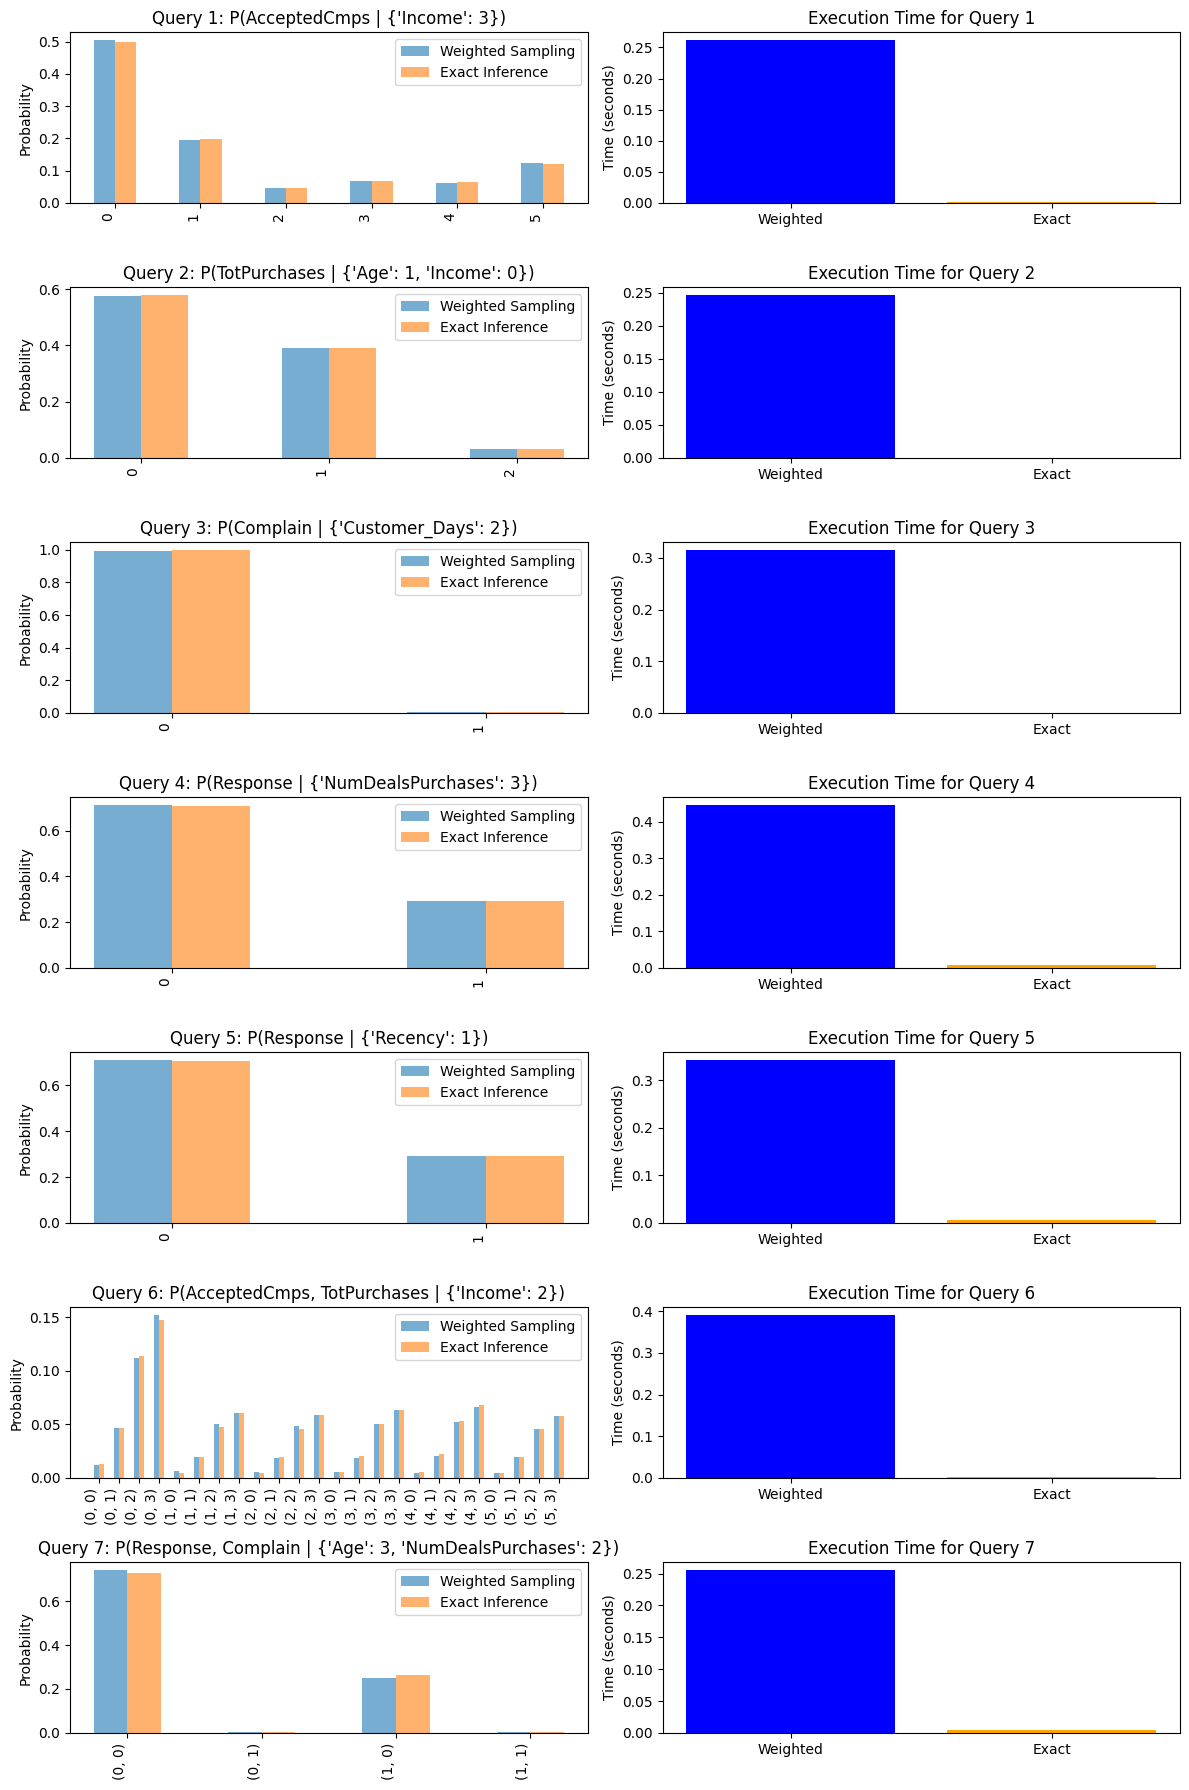

In [34]:
# Plot results
bar_width = 0.25
fig, axes = plt.subplots(len(queries), 2, figsize=(12, 18))
for i, q in enumerate(queries):
    # extracting weighted results
    weighted_dist = weighted_results[i]
    weighted_labels = list(weighted_results[i].index)

    # get exact values ordered according to weighted one
    order = sort_cpd(weighted_dist)
    exact_dist = exact_results[i]
    exact_values = [exact_dist.get_value(**state_dict) for state_dict in order]

    # Creating x positions
    x_pos = np.arange(len(weighted_labels))

    # Probability comparison plot
    axes[i, 0].bar(x_pos - bar_width / 2, weighted_dist, bar_width, alpha=0.6, label="Weighted Sampling")
    axes[i, 0].bar(x_pos + bar_width / 2, exact_values, bar_width, alpha=0.6, label="Exact Inference")

    # Set x-axis labels to weighted_labels
    axes[i, 0].set_xticks(x_pos)
    axes[i, 0].set_xticklabels(weighted_labels, rotation=90, ha="right")

    axes[i, 0].set_title(f"Query {i+1}: P({', '.join(q['query'])} | {q['evidence']})")
    axes[i, 0].set_ylabel("Probability")
    axes[i, 0].legend()

    # Execution time comparison plot
    axes[i, 1].bar(["Weighted", "Exact"], [weighted_times[i], exact_times[i]], color=['blue', 'orange'])
    axes[i, 1].set_title(f"Execution Time for Query {i+1}")
    axes[i, 1].set_ylabel("Time (seconds)")

plt.tight_layout()
plt.show()

In [46]:
# Translating back to continuous range to answer to queries
from sklearn import preprocessing
import pandas as pd

df = pd.read_csv('./data/data_simplified.csv')

def get_discrete_columns(df):
    res = []
    for col_name in df.columns:
        col = df[col_name]
        if col.dtype == 'object' or col.dtype == 'category' or col.dtype == 'bool' or col.nunique() <= 6:
            pass
        else:
            res.append(col_name)
    return res

# Identify columns
discrete_cols = get_discrete_columns(df)
categorical_cols = [col for col in df.columns if col not in discrete_cols]

# Initialize preprocessing objects
discretizer = preprocessing.KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
label_encoders = {col: preprocessing.LabelEncoder() for col in categorical_cols}

# Function to extract mapping of discrete numbers to ranges and categorical labels
def extract_range_map(df, discrete_cols, categorical_cols):
    mapping = {}

    # Process discretized continuous variables
    for col_name in discrete_cols:
        col = df[col_name].dropna().values.reshape(-1, 1)  # Reshape for KBinsDiscretizer
        discretizer.fit(col)

        # Get bin edges
        bin_edges = discretizer.bin_edges_[0]
        bin_ranges = {i: (bin_edges[i], bin_edges[i+1]) for i in range(len(bin_edges) - 1)}

        mapping[col_name] = bin_ranges

    # Process categorical variables (Label Encoding)
    for col_name in categorical_cols:
        le = label_encoders[col_name]
        df[col_name] = le.fit_transform(df[col_name])  # Encode the column
        class_mapping = {idx: label for idx, label in enumerate(le.classes_)}

        mapping[col_name] = class_mapping

    return mapping

# Extract mapping
mapping = extract_range_map(df, discrete_cols, categorical_cols)

# function to translate from encoded val to original range
def get_most_probable_outcomes(weighted_results, queries, mapping):
    for i, q in enumerate(queries):
        # Extract probability distribution for current query
        weighted_dist = weighted_results[i]

        # Find the most probable outcome
        max_state = weighted_dist.idxmax()
        max_prob = weighted_dist[max_state]

        # If query contains multiple variables, max_state will be a tuple
        if isinstance(max_state, tuple):
            most_probable_values = dict(zip(q["query"], max_state))
        else:
            most_probable_values = {q["query"][0]: max_state}

        # Convert numerical values back to original labels/ranges
        def format_value(var, val):
            if var in mapping:
                original = mapping[var].get(val, val)
                if isinstance(original, tuple):  # Convert range tuple (X, Y) to "from X to Y"
                    return f"from {original[0]} to {original[1]}"
                return original
            return val

        mapped_values = {var: format_value(var, val) for var, val in most_probable_values.items()}
        mapped_evidence = {var: format_value(var, val) for var, val in q["evidence"].items()}

        # Format for printing
        evidence_str = ", ".join([f"{k} {v}" for k, v in mapped_evidence.items()])
        outcome_str = ", ".join([f"{k} {v}" for k, v in mapped_values.items()])

        print(f"Given {evidence_str}, the most probable outcome is {outcome_str} with probability {max_prob:.4f}")

get_most_probable_outcomes(weighted_results, queries, mapping)


Given Income from 68274.0 to 113734.0, the most probable outcome is AcceptedCmps 0 with probability 0.5036
Given Age from 43.0 to 50.0, Income from 1730.0 to 35416.0, the most probable outcome is TotPurchases from 0.0 to 6.0 with probability 0.5752
Given Customer_Days from 2511.0 to 2688.0, the most probable outcome is Complain False with probability 0.9956
Given NumDealsPurchases from 3.0 to 15.0, the most probable outcome is Response False with probability 0.7096
Given Recency from 24.0 to 49.0, the most probable outcome is Response False with probability 0.7090
Given Income from 51412.0 to 68274.0, the most probable outcome is AcceptedCmps 0, TotPurchases from 18.0 to 32.0 with probability 0.1518
Given Age from 61.0 to 80.0, NumDealsPurchases from 2.0 to 3.0, the most probable outcome is Response False, Complain False with probability 0.7398


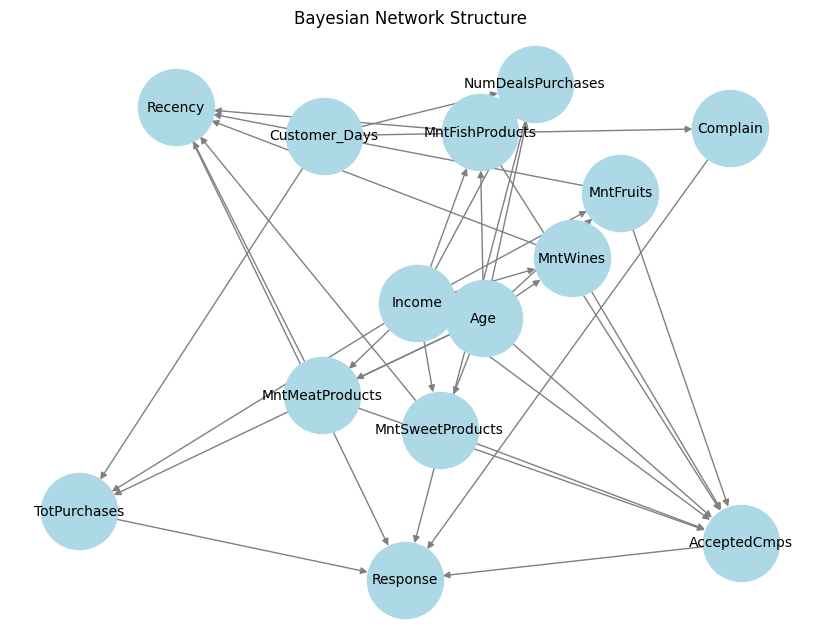

In [55]:
# creating network image
import networkx as nx
import matplotlib.pyplot as plt

# Create a networkx graph from the Bayesian Network
G = nx.DiGraph()
G.add_edges_from(bn.edges())

# Draw the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=67)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, edge_color="gray")
plt.title("Bayesian Network Structure")
plt.savefig("./data/bayesian_network.png", format="png", dpi=300)
